In [ ]:
pip install nltk

In [ ]:
pip install contractions

In [ ]:
!pip install spacy

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
import spacy
import contractions
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from gensim.models import KeyedVectors

## LOADING AND PREPROCESSING

In [ ]:
df=pd.read_excel('/content/topics.xlsx')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   title               10000 non-null  object        
 1   content             10000 non-null  object        
 2   content_word_count  10000 non-null  float64       
 3   published_date      10000 non-null  object        
 4   created_at          10000 non-null  datetime64[ns]
 5   updated_at          10000 non-null  datetime64[ns]
 6   language            10000 non-null  object        
 7   article_links       7104 non-null   object        
 8   total_share_count   9999 non-null   float64       
 9   keywords_status     9979 non-null   float64       
 10  keywords            9979 non-null   object        
 11  entities            9979 non-null   object        
 12  sentiment           9984 non-null   float64       
 13  title_sentiment     5107 non-null   float64   

In [ ]:
unique_topics= df['topic'].unique()
unique_topics

array(['business', 'sports', 'technology', 'health', 'unknown',
       'politics', 'travel', 'entertainment', 'fashion'], dtype=object)

### Keeping Important features only

In [ ]:
columns_to_keep = ['title', 'topic']
df = df[columns_to_keep]

### New Dataframe

In [ ]:
df.head()

,title,topic
0,Mitsubishi Motors Co. (OTCMKTS:MMTOF) Short In...,business
1,Juventus off the hook! Bianconeri set to have ...,sports
2,Dodgers ponder shortstop for Betts after pater...,sports
3,"Meta lays off tech teams, battering employee m...",technology
4,FDA clears extra COVID booster for some high-r...,health


In [ ]:
df = df.dropna()
df = df.drop_duplicates()
df.isnull().sum()

In [ ]:
topic=df['topic'].value_counts()
topic

topic
technology       1668
business         1594
unknown          1461
sports           1293
politics         1206
entertainment    1171
travel            655
health            603
fashion           288
Name: count, dtype: int64

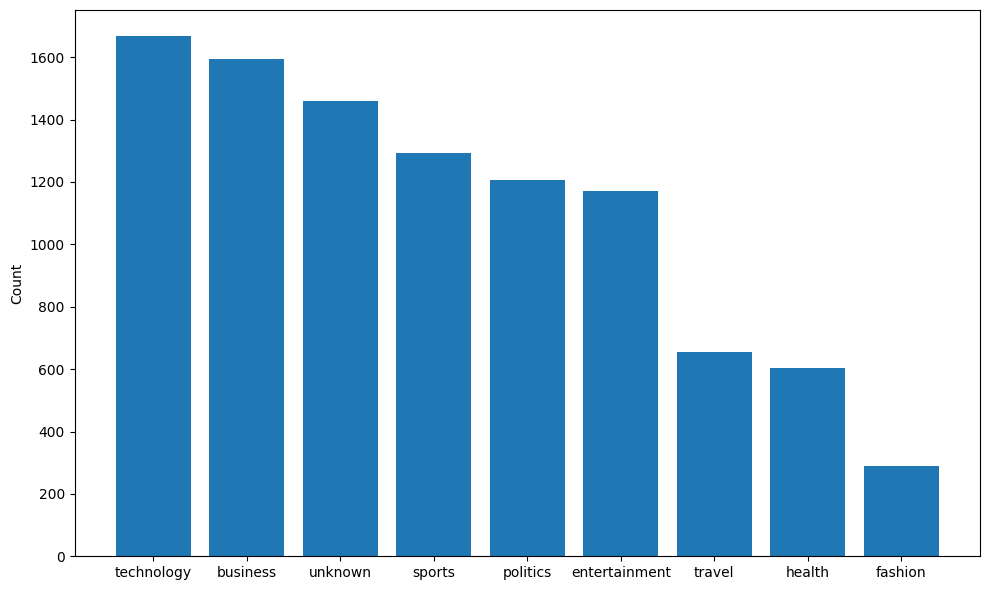

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(topic.index, topic.values)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Steps for preprocessing :

1. Tokenization
2. Lowercasing
3. Removing Stopwords
4. Removing Punctuation
5. Handle contraction and #abbreviation
6. Remove special characters
7. Lemmatization
8. Run NER to identify named entities (makes slow) x

In [ ]:
lemmatizer = WordNetLemmatizer()
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)  # Tokenization
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
    return ' '.join(lemmatized_tokens)

df['title'] = df['title'].apply(tokenize_and_lemmatize)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df['title'] = df['title'].str.lower()

In [ ]:
custom_stopwords = ['the', 'a', 'of', 'and', 'to', 'in', 'is', 'it', 'is', 'am', 'are', 'was', 'were', 'an', 'in', \
                'at' , 'you', 'for', 'i', 'on', 'they', 'he', 'him', 'his', 'her', 'himself', 'it', 'they', 'them',\
                'this', 'that', 'these', 'those', 'be', 'by']

def stopwords_removal(tt):
    # Split -> Filter -> Join
    if isinstance (tt,str):
        words = tt.split()
        filtered_words = [w for w in words if w not in custom_stopwords]
        filtered_tweet = ' '.join(filtered_words)
        return filtered_tweet
    else:
        return tt

df['title'] = df['title'].apply(stopwords_removal)

In [ ]:
def remove_punctuation(TT):
    return TT.str.replace(r'[^\w\s]', '')

df['title'] = remove_punctuation(df['title'])

In [ ]:
def fix_contractions(ttl:str) -> str:
    return contractions.fix(ttl)

df['title'] = df['title'].apply(lambda x: fix_contractions(x) if isinstance(x, str) else x)

In [ ]:
df['title'] = df['title'].str.replace("'", '').str.replace('"','') #removing atostrophe

In [1]:
def handle_specials(t: str) -> str:
    ## Ord(character) will give you the integer value for that character. Since standard ASCII range is from
    # 0 to 127, any thing after that will contribute to emojis, and weird characters like "Å© ‚Å¶, üòÇ"
    #  This is Apple logo
    t = ''.join([x for x in t if ord(x) < 128])
    t = re.sub(r'http\S+|www\S+|https\S+', '', t) # Remove Links
    t = re.sub("@[A-Za-z0-9_]+","", t) # Remove mentions @Juggernaut
    t = re.sub("#[A-Za-z0-9_]+","", t) # Remove hashtags #Necromancer

    # We have tweets like -> FREEDOM\nFREEDOM\nFREEDOM \n\nBUSY BUSY BUSY\n -> We need to remove "\n"
    # We also have to deal with the trailing dpulication problem here.
    t = t.strip().replace('\n', '') # Replace \n with whitespace
    t = re.sub(r'\b(\w+)( \1\b)+', r'\1', t, flags=re.IGNORECASE) # Reduce any trailing words

    # Only keep english letter(Cap and small) & numbers
    # We also should not remove aphostrophe('), because we need them in handling contractions. (won't, can't)
    # But we also notice that we have structure 'create chaos', 'massive and amazing', where the
    # aphostrophe does not mean contractions so we need to remove them after contraction handling step.
    t = re.sub(r"[^a-zA-Z0-9'\s]", ' ', t)
    t = re.sub(r'\s+', ' ', t).strip() # Convert all the trailing whitespaces to one whitespace
    return t

df['title'] = df['title'].apply(handle_specials)

NameError: name 'df' is not defined

In [ ]:
df[:25]

,title,topic
0,mitsubishi motor co otcmkts mmtof short interest update,business
1,juventus off hook bianconeri set have 15 point deduction overturned propel into serie top fourjuventus off hook bianconeri set have 15 point deduction overturned propel into serie top four goal com australia,sports
2,dodger ponder shortstop betts after paternity leave,sports
3,meta lay off tech team battering employee morale reuters,technology
4,fda clear extra covid booster some high risk american,health
5,bicep curl drop set pump your gun maximize muscle gain,unknown
6,mid level environmental engineer job boeing renton wa,business
7,lagos sue teenager making hoax call fire service ladun liadi s blog,politics
8,abdullah hakeem short reminder istighfar tawbah,unknown
9,de zerbi maintains midas touch brighton success story continues,sports


### Label Encoding for the 'topic' column

In [ ]:
label_encoder=LabelEncoder()
df['topic_encoded'] = label_encoder.fit_transform(df['topic'])
df['topic_encoded'].unique()

array([0, 5, 6, 3, 8, 4, 7, 1, 2])

In [ ]:
mapping = {topic.index[i]: topic.iloc[i] for i in range(len(topic))}
print("Encoded Topic Mapping:")
for topic, encoded_value in mapping.items():
    print(f"Topic: {topic} : {encoded_value}")


Encoded Topic Mapping:
Topic: technology : 1668
Topic: business : 1594
Topic: unknown : 1461
Topic: sports : 1293
Topic: politics : 1206
Topic: entertainment : 1171
Topic: travel : 655
Topic: health : 603
Topic: fashion : 288


In [ ]:
# Load pre-trained GloVe word embeddings
word_vectors = dict()
def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue
add_to_dict(word_vectors, '/content/glove.6B.50d.txt')  #Glove pre-trained corpus model to represent the tweets
word_vectors

In [ ]:
# Prepare data
def txt_to_wectors(message, word_dict=words):
  processed_list_of_tokens = tokenize_and_lemmatize(message)

  vectors = []

  for token in processed_list_of_tokens:
    if token not in word_dict:
      continue

    token_vector = word_dict[token]
    vectors.append(token_vector)

  return np.array(vectors, dtype=float)

In [ ]:
train_df = df.sample(frac=1, random_state=1)
train_df.reset_index(drop=True, inplace=True)

split_index_1 = int(len(train_df) * 0.7)
split_index_2 = int(len(train_df) * 0.85)

train_df, val_df, test_df = train_df[:split_index_1], train_df[split_index_1:split_index_2], train_df[split_index_2:]

len(train_df), len(val_df), len(test_df)

(6957, 1491, 1491)

In [ ]:
def df_to_X_y(dff):
  y = dff['topic_encoded'].to_numpy().astype(int)

  all_word_vector_sequences = []

  for message in dff['title']:
    message_as_vector_seq = message_to_word_vectors(str(message))

    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_seq)

  return all_word_vector_sequences, y

In [ ]:
X_train, y_train = df_to_X_y(train_df)

print(len(X_train), len(X_train[181]))

6957 28


In [ ]:
print(y_train[120])

5


(array([2.280e+02, 1.381e+03, 3.181e+03, 1.560e+03, 4.480e+02, 9.800e+01,
        3.400e+01, 1.300e+01, 1.100e+01, 3.000e+00]),
 array([  1. ,  20.5,  40. ,  59.5,  79. ,  98.5, 118. , 137.5, 157. ,
        176.5, 196. ]),
 <BarContainer object of 10 artists>)

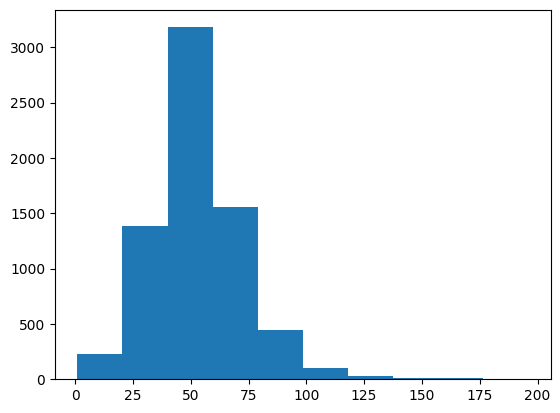

In [ ]:
sequence_lengths = []

for i in range(len(X_train)):
  sequence_lengths.append(len(X_train[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)

In [ ]:
pd.Series(sequence_lengths).describe()

count    6957.000000
mean       52.854248
std        19.886930
min         1.000000
25%        41.000000
50%        51.000000
75%        63.000000
max       196.000000
dtype: float64

In [ ]:
from copy import deepcopy

def pad_X(X, desired_sequence_length=200):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len

    pad = np.zeros(shape=(sequence_length_difference, 50))

    X_copy[i] = np.concatenate([x, pad])

  return np.array(X_copy).astype(float)

In [ ]:
X_train = pad_X(X_train)

X_train.shape

(6957, 200, 50)

####
X_train has 6957 samples.
Each sample has been padded (or truncated) to a length of 200.
Each sample has 50 features.

In [ ]:
X_val, y_val = df_to_X_y(val_df)
X_val = pad_X(X_val)

X_val.shape, y_val.shape

((1491, 200, 50), (1491,))

In [ ]:
X_test, y_test = df_to_X_y(test_df)
X_test = pad_X(X_test)

X_test.shape, y_test.shape

((1491, 200, 50), (1491,))

In [ ]:
if X_train.ndim > 2:
    X_train = X_train.reshape(X_train.shape[0], -1)

# Standardize the features if needed
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
# Train SVM classifier
svm_classifier = SVC(kernel='poly')
svm_classifier.fit(X_train_scaled, y_train)

SVC(kernel='poly')

In [ ]:
# Predictions
y_pred = svm_classifier.predict(X_test)

In [ ]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.17639168343393696
